In [12]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

import networkx as nx
import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,6)


In [13]:
# Update path if needed
df = pd.read_csv("CloudWatch_Traffic_Web_Attack.csv")

print("Dataset Loaded Successfully")
df.head()


Dataset Loaded Successfully


,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


In [14]:
print("Shape:", df.shape)
print("\nColumns:\n", df.columns)
print("\nInfo:")
df.info()

print("\nNumerical Summary:")
df.describe()

print("\nCategorical Summary:")
df.describe(include="object")


Shape: (282, 16)

Columns:
 Index(['bytes_in', 'bytes_out', 'creation_time', 'end_time', 'src_ip',
       'src_ip_country_code', 'protocol', 'response.code', 'dst_port',
       'dst_ip', 'rule_names', 'observation_name', 'source.meta',
       'source.name', 'time', 'detection_types'],
      dtype='object')

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bytes_in             282 non-null    int64 
 1   bytes_out            282 non-null    int64 
 2   creation_time        282 non-null    object
 3   end_time             282 non-null    object
 4   src_ip               282 non-null    object
 5   src_ip_country_code  282 non-null    object
 6   protocol             282 non-null    object
 7   response.code        282 non-null    int64 
 8   dst_port             282 non-null    int64 
 9   dst_ip               282 non-null   

,creation_time,end_time,src_ip,src_ip_country_code,protocol,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
count,282,282,282,282,282,282,282,282,282,282,282,282
unique,30,30,28,7,1,1,1,1,1,1,30,1
top,2024-04-26T09:00:00Z,2024-04-26T09:10:00Z,165.225.209.4,US,HTTPS,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26T09:00:00Z,waf_rule
freq,17,17,29,113,282,282,282,282,282,282,17,282


In [15]:
# Remove duplicates
df = df.drop_duplicates()

# Convert time columns to datetime
df['creation_time'] = pd.to_datetime(df['creation_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['time'] = pd.to_datetime(df['time'])

# Standardize country code
df['src_ip_country_code'] = df['src_ip_country_code'].str.upper()

print("Data Cleaning Completed")
df.info()


Data Cleaning Completed
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   bytes_in             282 non-null    int64              
 1   bytes_out            282 non-null    int64              
 2   creation_time        282 non-null    datetime64[ns, UTC]
 3   end_time             282 non-null    datetime64[ns, UTC]
 4   src_ip               282 non-null    object             
 5   src_ip_country_code  282 non-null    object             
 6   protocol             282 non-null    object             
 7   response.code        282 non-null    int64              
 8   dst_port             282 non-null    int64              
 9   dst_ip               282 non-null    object             
 10  rule_names           282 non-null    object             
 11  observation_name     282 non-null    object             
 12

In [16]:
# Session duration in seconds
df['session_duration'] = (df['end_time'] - df['creation_time']).dt.total_seconds()

# Average packet size
df['avg_packet_size'] = (df['bytes_in'] + df['bytes_out']) / df['session_duration']

df[['session_duration', 'avg_packet_size']].head()


,session_duration,avg_packet_size
0,600.0,30.986667
1,600.0,81.830000
2,600.0,69.956667
3,600.0,74.706667
4,600.0,34.030000


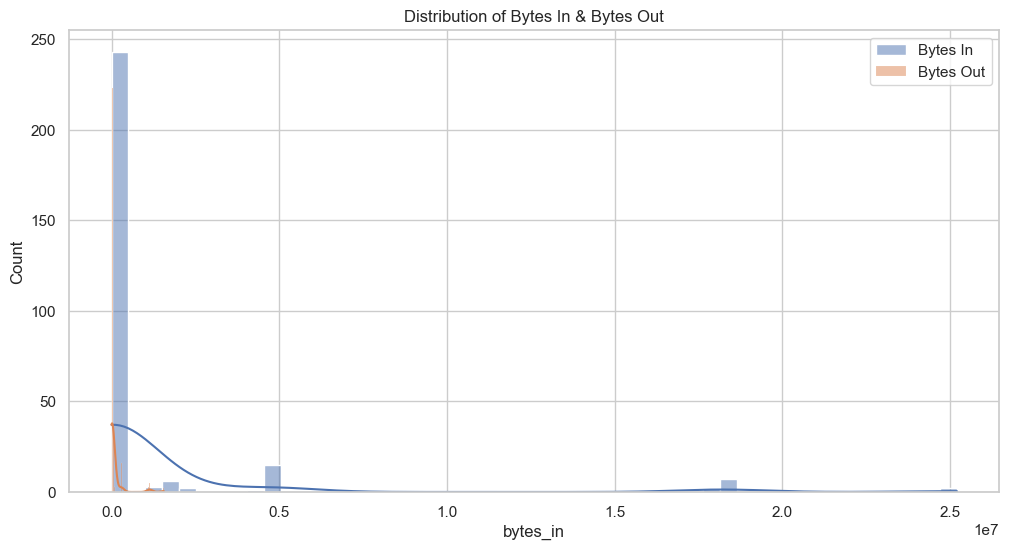

In [17]:
sns.histplot(df['bytes_in'], bins=50, kde=True, label='Bytes In')
sns.histplot(df['bytes_out'], bins=50, kde=True, label='Bytes Out')
plt.legend()
plt.title("Distribution of Bytes In & Bytes Out")
plt.show()


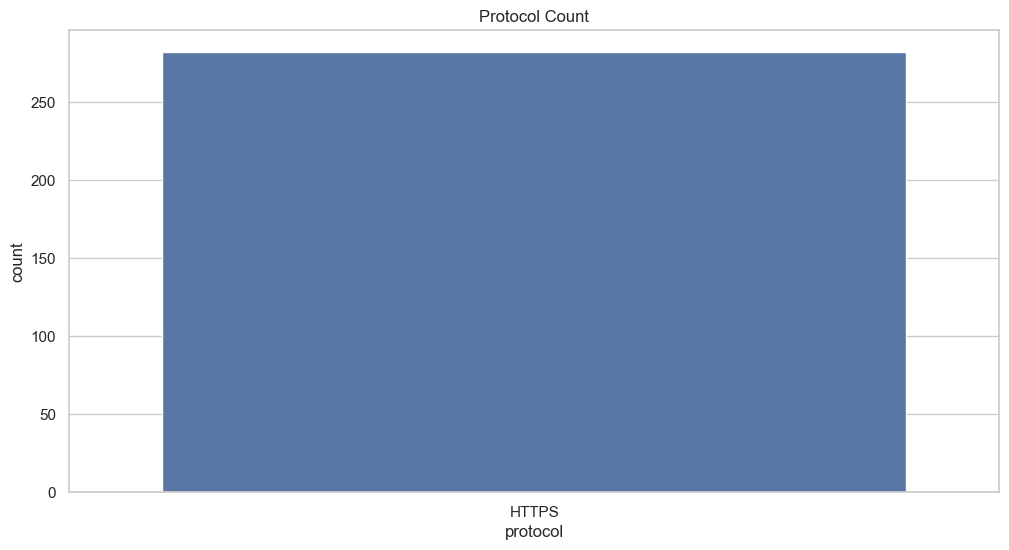

In [18]:
sns.countplot(x='protocol', data=df)
plt.title("Protocol Count")
plt.show()


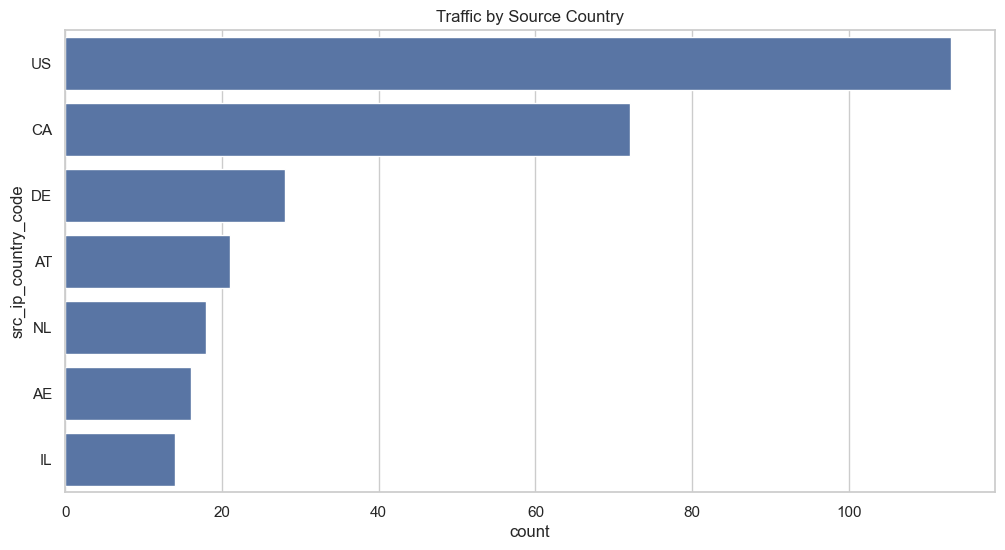

In [19]:
sns.countplot(y='src_ip_country_code',
              order=df['src_ip_country_code'].value_counts().index,
              data=df)
plt.title("Traffic by Source Country")
plt.show()


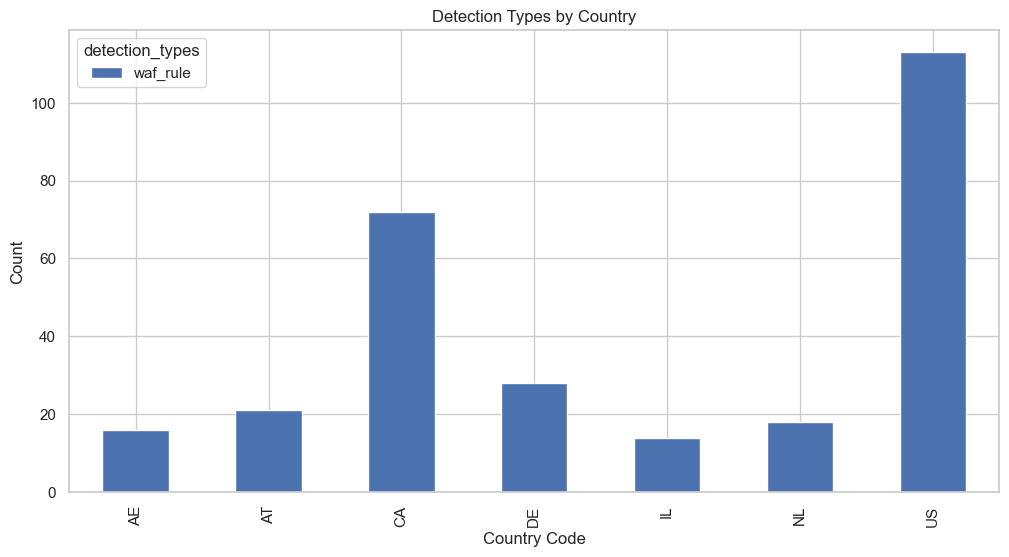

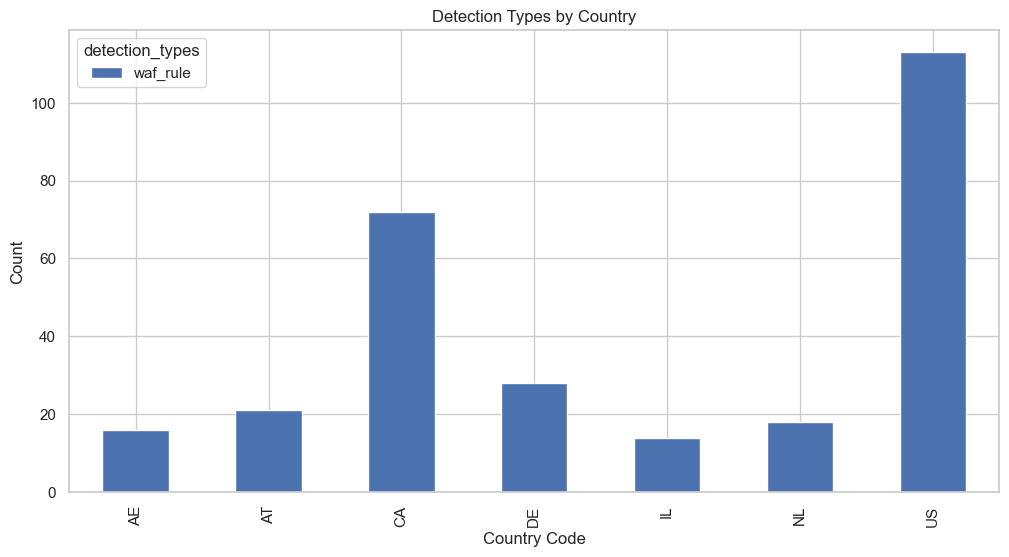

In [20]:
pd.crosstab(df['src_ip_country_code'], df['detection_types']).plot(
    kind='bar', stacked=True)
plt.title("Detection Types by Country")
plt.xlabel("Country Code")
plt.ylabel("Count")
plt.show()
pd.crosstab(df['src_ip_country_code'], df['detection_types']).plot(
    kind='bar', stacked=True)
plt.title("Detection Types by Country")
plt.xlabel("Country Code")
plt.ylabel("Count")
plt.show()


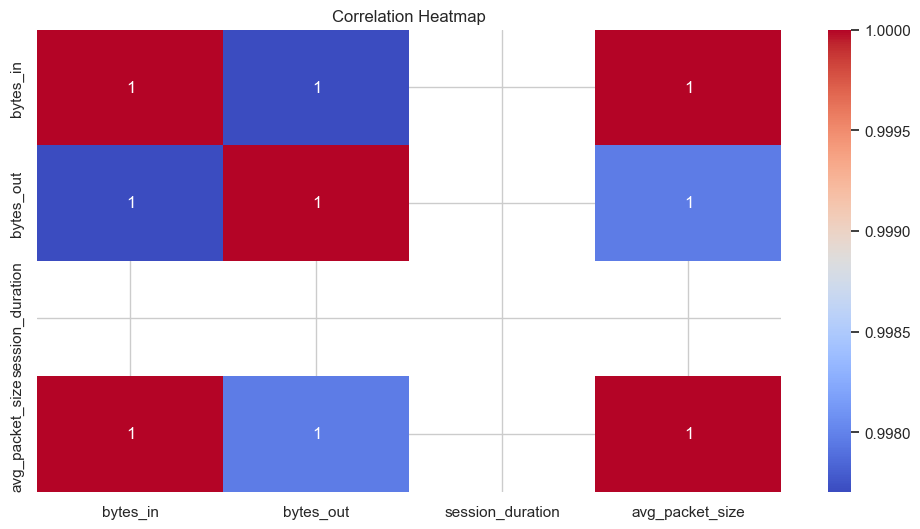

In [21]:
numeric_df = df[['bytes_in', 'bytes_out', 'session_duration', 'avg_packet_size']]
corr = numeric_df.corr()

sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


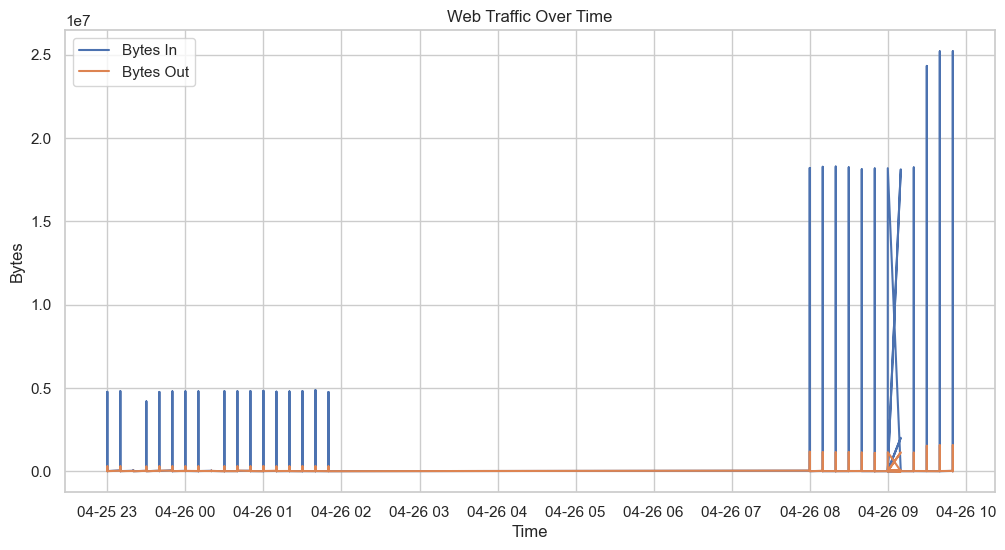

In [22]:
df_time = df.set_index('creation_time')

plt.plot(df_time.index, df_time['bytes_in'], label='Bytes In')
plt.plot(df_time.index, df_time['bytes_out'], label='Bytes Out')
plt.legend()
plt.title("Web Traffic Over Time")
plt.xlabel("Time")
plt.ylabel("Bytes")
plt.show()


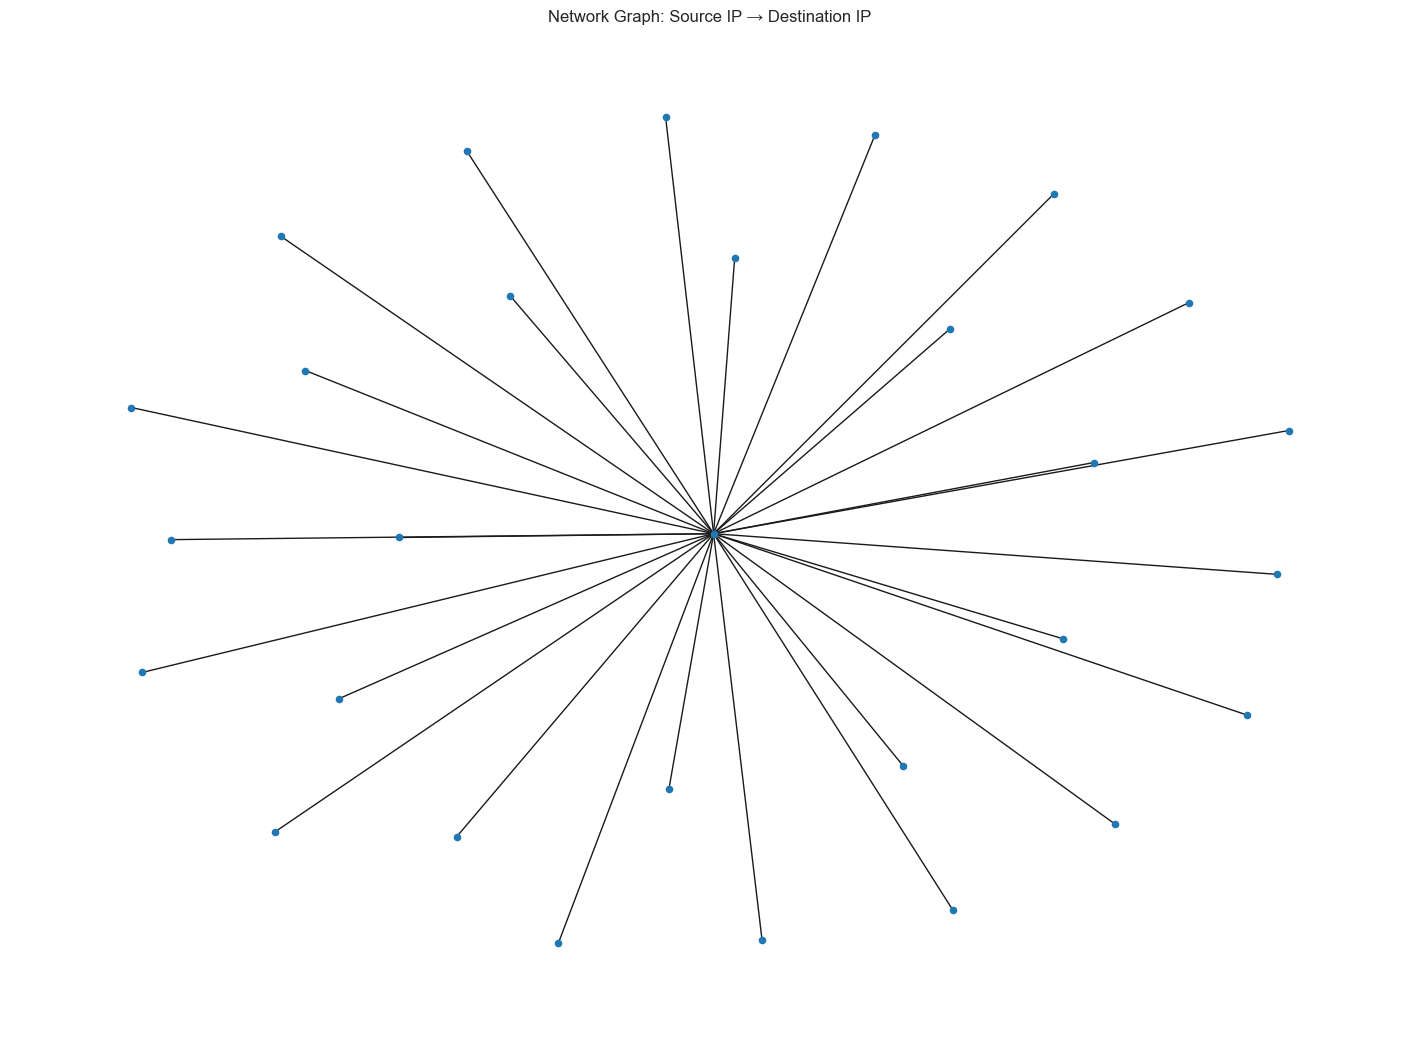

In [23]:
G = nx.Graph()

for _, row in df.iterrows():
    G.add_edge(row['src_ip'], row['dst_ip'])

plt.figure(figsize=(14,10))
nx.draw(G, node_size=20, with_labels=False)
plt.title("Network Graph: Source IP → Destination IP")
plt.show()


In [24]:
features = df[['bytes_in', 'bytes_out', 'session_duration', 'avg_packet_size']]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['anomaly'] = iso_forest.fit_predict(features_scaled)

df['anomaly'] = df['anomaly'].map({1:'Normal', -1:'Suspicious'})
df['anomaly'].value_counts()


anomaly
Normal        267
Suspicious     15
Name: count, dtype: int64

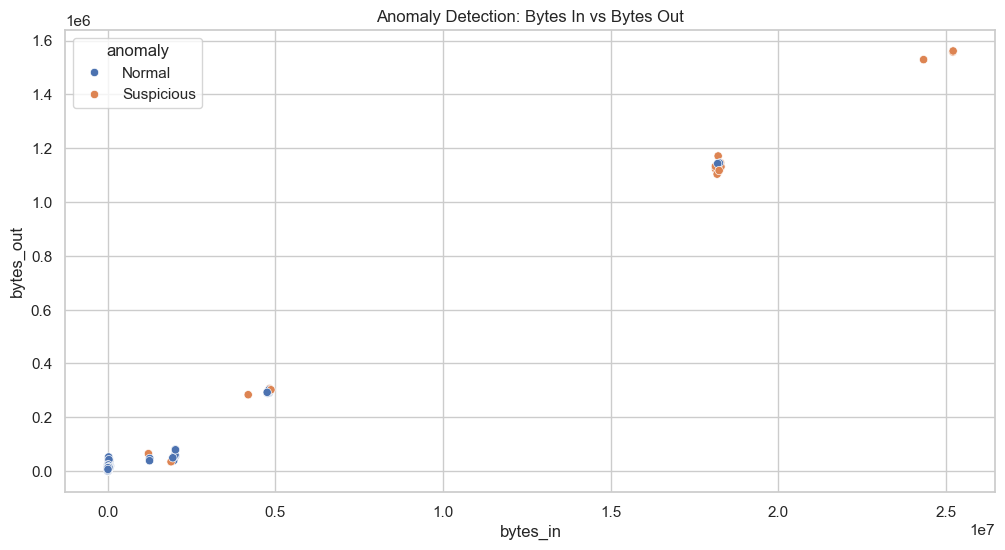

In [25]:
sns.scatterplot(x='bytes_in', y='bytes_out', hue='anomaly', data=df)
plt.title("Anomaly Detection: Bytes In vs Bytes Out")
plt.show()


In [26]:
df['is_suspicious'] = (df['detection_types'] == 'waf_rule').astype(int)


In [27]:
X = df[['bytes_in', 'bytes_out', 'session_duration']]
y = df['is_suspicious']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


In [29]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)


In [30]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        85

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85

